In [1]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from IPython.display import Audio, display

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# List of classes to use
CLASSES = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]



Using device: cuda


In [2]:
# Helper to filter dataset by class
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        custom_path = r"D:\Python Projects\Envision Project\Dataset\speech_commands_v0.02"
        if os.path.exists(custom_path):
            print(f"Using dataset found at: {custom_path}")
            root = r"D:\Python Projects\Envision Project\Dataset"
            download = False
        else:
            print("Dataset not found at custom path, downloading to default location...")
            root = "./"
            download = True
        super().__init__(root=root, download=download)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in f]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

# Load datasets
try:
    train_set = SubsetSC("training")
    val_set = SubsetSC("validation")
    test_set = SubsetSC("testing")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Attempting to download dataset to default location...")
    train_set = SubsetSC("training")
    val_set = SubsetSC("validation")
    test_set = SubsetSC("testing")
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")



Dataset not found at custom path, downloading to default location...


100%|██████████| 2.26G/2.26G [00:23<00:00, 102MB/s]


Dataset not found at custom path, downloading to default location...
Dataset not found at custom path, downloading to default location...
Train set size: 84843
Validation set size: 9981


Sample rate: 16000
Waveform shape: torch.Size([1, 16000])
Label: down


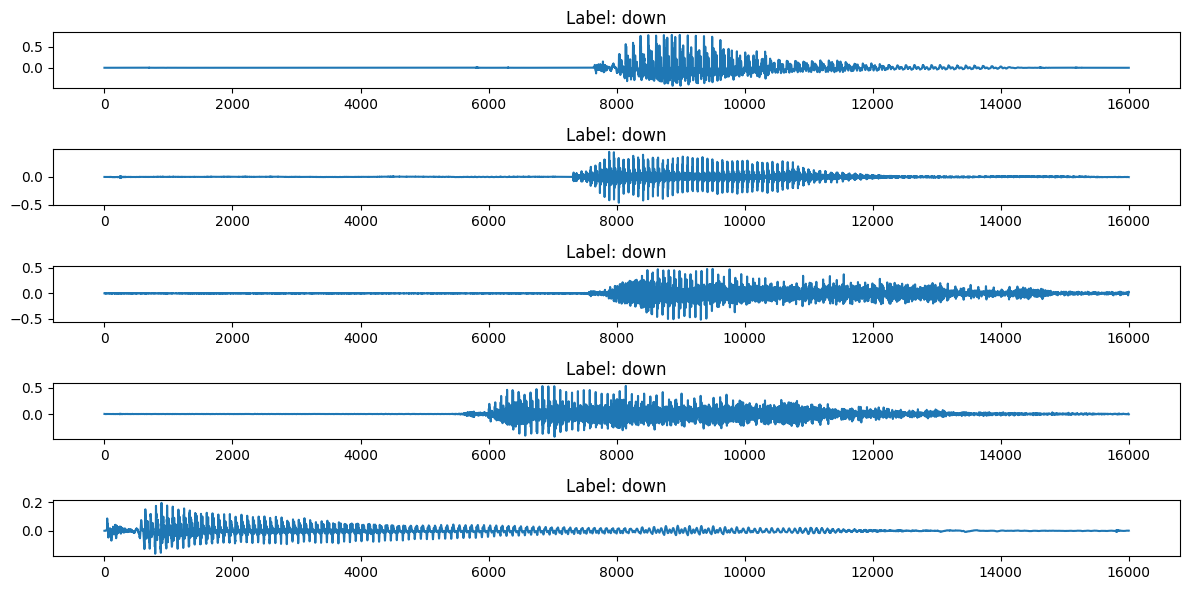

Label: down


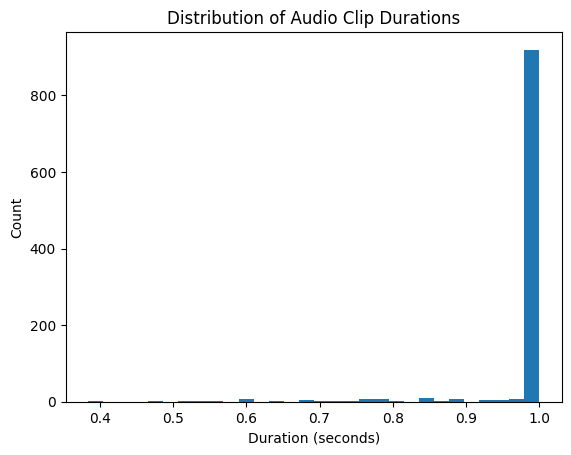

Min duration: 0.38s, Max duration: 1.00s, Mean: 0.98s


In [3]:
# Filter samples to only include selected classes
def filter_classes(dataset, classes):
    indices = []
    for idx in range(len(dataset)):
        _, _, label, *_ = dataset[idx]
        if label in classes:
            indices.append(idx)
    return indices

train_indices = filter_classes(train_set, CLASSES)
val_indices = filter_classes(val_set, CLASSES)
test_indices = filter_classes(test_set, CLASSES)

# Check one sample
sample_waveform, sample_sr, sample_label, *_ = train_set[train_indices[0]]
print("Sample rate:", sample_sr)
print("Waveform shape:", sample_waveform.shape)
print("Label:", sample_label)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(train_indices[:5]):
    waveform, sr, label, *_ = train_set[idx]
    plt.subplot(5, 1, i+1)
    plt.plot(waveform.t().numpy())
    plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

waveform, sr, label, *_ = train_set[train_indices[0]]
print("Label:", label)
display(Audio(waveform.numpy(), rate=sr))

durations = []
for idx in train_indices[:1000]:
    waveform, sr, _, *_ = train_set[idx]
    durations.append(waveform.shape[1] / sr)
plt.hist(durations, bins=30)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of Audio Clip Durations")
plt.show()
print(f"Min duration: {min(durations):.2f}s, Max duration: {max(durations):.2f}s, Mean: {np.mean(durations):.2f}s")



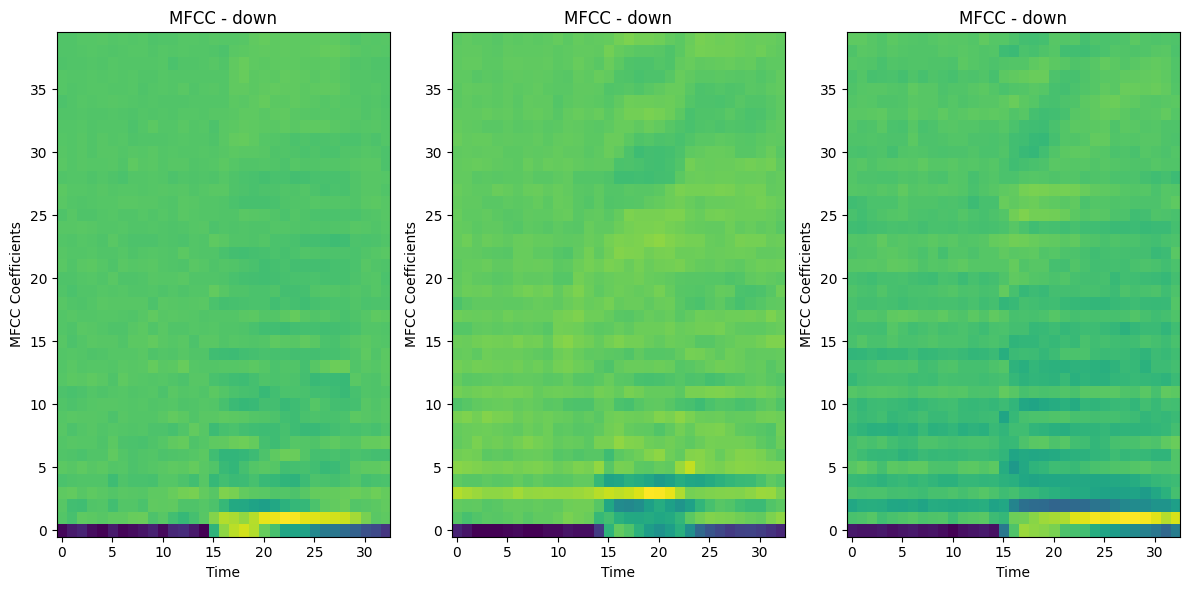

In [4]:
# MFCC parameters
N_MFCC = 40
N_FFT = 1024
HOP_LENGTH = 500
N_MELS = 64

mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_sr,
    n_mfcc=N_MFCC,
    melkwargs={"n_fft": N_FFT, "hop_length": HOP_LENGTH, "n_mels": N_MELS}
)

# Visualize MFCCs for a few samples
plt.figure(figsize=(12, 6))
for i, idx in enumerate(train_indices[:3]):
    waveform, sr, label, *_ = train_set[idx]
    mfcc = mfcc_transform(waveform)
    plt.subplot(1, 3, i+1)
    plt.imshow(mfcc[0].detach().numpy(), aspect='auto', origin='lower')
    plt.title(f"MFCC - {label}")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()



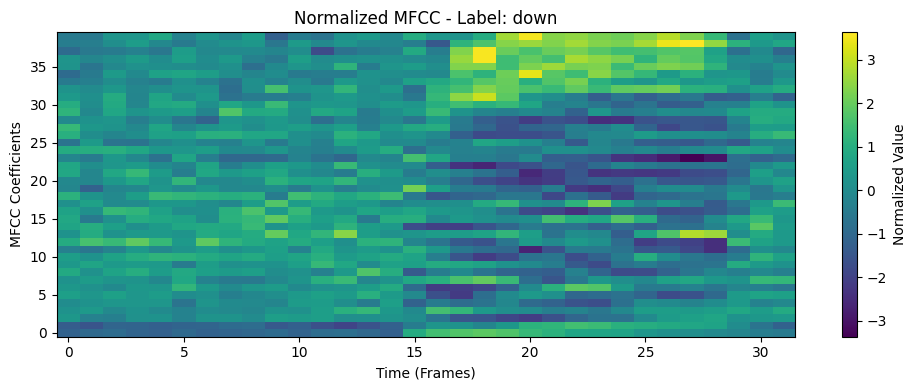

In [5]:
# Set max sequence length manually
MAX_SEQ_LEN = 32

# Compute mean and std for normalization (on training set)
all_feats = []
for idx in train_indices[:1000]:  # Use a subset for speed
    waveform, _, label, *_ = train_set[idx]
    mfcc = mfcc_transform(waveform)[0].T
    if mfcc.shape[0] < MAX_SEQ_LEN:
        pad = torch.zeros(MAX_SEQ_LEN - mfcc.shape[0], mfcc.shape[1])
        mfcc = torch.cat([mfcc, pad], dim=0)
    else:
        mfcc = mfcc[:MAX_SEQ_LEN, :]
    all_feats.append(mfcc)
all_feats = torch.stack(all_feats)
mean = all_feats.mean(dim=(0, 1))
std = all_feats.std(dim=(0, 1))

# Custom dataset class
class SpeechCommandsDataset(Dataset):
    def __init__(self, base_dataset, indices, mfcc_transform, max_seq_len, class_list, mean=None, std=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.mfcc_transform = mfcc_transform
        self.max_seq_len = max_seq_len
        self.class_to_idx = {c: i for i, c in enumerate(class_list)}
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        waveform, _, label, *_ = self.base_dataset[idx]
        mfcc = self.mfcc_transform(waveform)[0].T  # (time, n_mfcc)
        if mfcc.shape[0] < self.max_seq_len:
            pad = torch.zeros(self.max_seq_len - mfcc.shape[0], mfcc.shape[1])
            mfcc = torch.cat([mfcc, pad], dim=0)
        else:
            mfcc = mfcc[:self.max_seq_len, :]
        if self.mean is not None and self.std is not None:
            mfcc = (mfcc - self.mean) / self.std
        return mfcc, self.class_to_idx[label]

# Create datasets with fixed MAX_SEQ_LEN = 32
train_ds = SpeechCommandsDataset(train_set, train_indices, mfcc_transform, MAX_SEQ_LEN, CLASSES, mean, std)
val_ds = SpeechCommandsDataset(val_set, val_indices, mfcc_transform, MAX_SEQ_LEN, CLASSES, mean, std)
test_ds = SpeechCommandsDataset(test_set, test_indices, mfcc_transform, MAX_SEQ_LEN, CLASSES, mean, std)

# Collate function
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs)
    ys = torch.tensor(ys)
    return xs, ys

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Example visualization of normalized MFCC
mfcc_feat, label_idx = train_ds[0]
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_feat.T.numpy(), aspect='auto', origin='lower')
plt.title(f"Normalized MFCC - Label: {CLASSES[label_idx]}")
plt.xlabel("Time (Frames)")
plt.ylabel("MFCC Coefficients")
plt.colorbar(label="Normalized Value")
plt.tight_layout()
plt.show()
